In [1]:
# Python imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Trieste imports
from trieste.data import Dataset
from trieste.models.gpflow import GaussianProcessRegression, build_gpr
from trieste.space import Box
from trieste.acquisition.function.function import ExpectedImprovement
from trieste.acquisition.rule import EfficientGlobalOptimization
from trieste.bayesian_optimizer import BayesianOptimizer
from trieste.objectives.utils import mk_observer


# Local imports
import sys
sys.path.append("../../online_neuro")

from online_neuro.bayessian_optimizer import AskTellOptimizerHistory
from online_neuro.custom_acquisitions import ExpectedImprovementXsi

2025-12-19 10:32:36.066198: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-19 10:32:36.068382: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-19 10:32:36.112695: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-19 10:32:36.113448: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-19 10:32:36.748961: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

## Greedy Expected Improvement
This notebook compares a variant of the Expected Improvement (EI) acquisition by introducing a xsi parameter (ExpectedImprovementXsi) to produce explorative (xsi>0) or exploitative (xsi<0) behavior. If xsi==0, then it behaves as the standard EI

Benchmark can be run over different 1D objective functions (forrester, shubert, quartic, sine_mixture).
Steps:
- Select function (default: sine_mixture) and prepare initial dataset.
- Build GP regression model (Trieste / GPflow).
- Initialize acquisition functions ExpectedImprovementXsi with different xsi values to compare exploration vs exploitation.

Key parameters to tweak
- xsi (controls exploration vs exploitation)
- bo_iter (number of BO iterations)


In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# 1. DEFINE THE PROBLEMS
def shubert(x):
    term1 = 0
    for i in range(1, 6):
        term1 += i * tf.cos((i + 1) * x + i)
    return term1

def forrester(x):
    return (6*x - 2)**2 * tf.sin(12*x - 4)

def quartic(x):
    return (x - 0.7)**4 + 3 * (x - 0.5)**2

def sine_mixture(x):
    return (x + 1)**2 + tf.sin(5 * np.pi * x)**2

functions = {
    "forrester": forrester,
    "shubert": shubert,
    "quartic": quartic,
    "sine_mixture": sine_mixture
}

search_spaces = {
    "forrester": Box([0], [1]),
    "shubert": Box([-10], [10]),
    "quartic": Box([0], [1]),
    "sine_mixture": Box([-1], [2])
}


In [ ]:
# 2. SETUP EXPERIMENT
fun_name = 'sine_mixture'
search_space = search_spaces[fun_name]
lower_bound = search_space.lower.numpy()[0]
upper_bound = search_space.upper.numpy()[0]

# Some initial points to build the first model
x_linspace = np.linspace(lower_bound, upper_bound, 12)
X_initial = np.array([[x] for x in x_linspace[1::3]])  # Select every 3rd point
Y_initial = functions[fun_name](X_initial)
initial_dataset = Dataset(X_initial, Y_initial)

# 3. BUILD THE GAUSSIAN PROCESS MODEL
# Use a standard GPR model from Trieste
gp_flow_model = build_gpr(initial_dataset, search_space, likelihood_variance=1e-5)
model = GaussianProcessRegression(gp_flow_model)
acq = ExpectedImprovement()
original_ei = acq.prepare_acquisition_function(model, initial_dataset)

In [5]:
# 4. PREPARE THE THREE ACQUISITION FUNCTIONS FOR COMPARISON
# Original EI (equivalent to xsi=0)
original_ei_builder = ExpectedImprovementXsi(xsi=0.0)
original_acq = original_ei_builder.prepare_acquisition_function(model, initial_dataset)

# Explorative EI (xsi > 0)
explorative_ei_builder = ExpectedImprovementXsi(xsi=0.02)
explorative_acq = explorative_ei_builder.prepare_acquisition_function(model, initial_dataset)

# Exploitative EI (xsi < 0)
exploitative_ei_builder = ExpectedImprovementXsi(xsi=-0.02)
exploitative_acq = exploitative_ei_builder.prepare_acquisition_function(model, initial_dataset)


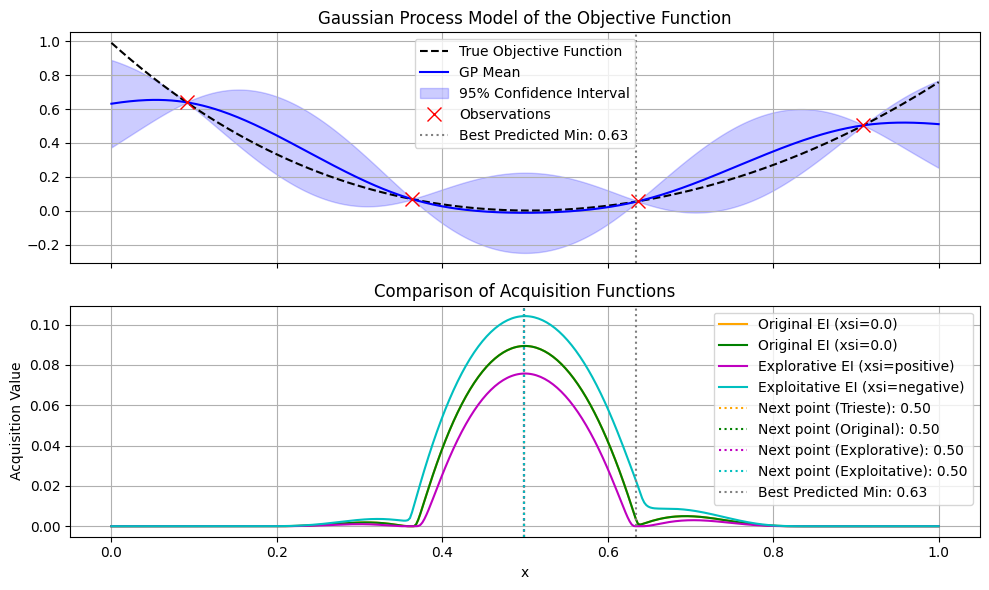

In [6]:
# 5. PLOT THE COMPARISON
# Create a dense grid of points to plot over
xx = np.linspace(lower_bound, upper_bound, 400).reshape(-1, 1)

# Get model predictions for the plot
mean, var = model.predict(xx)
std = np.sqrt(var.numpy())
mean = mean.numpy()

# Evaluate each acquisition function on the grid
acq_trieste_vals= np.array([original_ei(x.reshape(1, 1, -1)) for x in xx]).squeeze()
acq_orig_vals = np.array([original_acq(x.reshape(1, 1, -1)) for x in xx]).squeeze()
acq_explore_vals = np.array([explorative_acq(x.reshape(1, 1, -1)) for x in xx]).squeeze()
acq_exploit_vals = np.array([exploitative_acq(x.reshape(1, 1, -1)) for x in xx]).squeeze()

# Find the location of the maximum for each acquisition function
best_trieste = xx[np.argmax(acq_trieste_vals)]
best_orig = xx[np.argmax(acq_orig_vals)]
best_explore = xx[np.argmax(acq_explore_vals)]
best_exploit = xx[np.argmax(acq_exploit_vals)]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

best_min = np.argmin((mean + 1.96 * std).flatten())
# Plot 1: GP Model and True Function
ax1.plot(xx, functions[fun_name](xx), 'k--', label='True Objective Function')
ax1.plot(xx, mean, 'b', label='GP Mean')
ax1.fill_between(xx.flatten(), (mean - 1.96 * std).flatten(), (mean + 1.96 * std).flatten(), color='b', alpha=0.2, label='95% Confidence Interval')
ax1.plot(initial_dataset.query_points, initial_dataset.observations, 'rx', markersize=10, label='Observations')
ax1.axvline(xx[best_min], color='gray', linestyle=':', label=f'Best Predicted Min: {xx[best_min][0]:.2f}')
ax1.set_title('Gaussian Process Model of the Objective Function')
ax1.legend()
ax1.grid()

# Plot 2: Acquisition Functions
ax2.plot(xx, acq_trieste_vals, 'orange', label='Original EI (xsi=0.0)')
ax2.plot(xx, acq_orig_vals, 'g', label='Original EI (xsi=0.0)')
ax2.plot(xx, acq_explore_vals, 'm', label='Explorative EI (xsi=positive)')
ax2.plot(xx, acq_exploit_vals, 'c', label='Exploitative EI (xsi=negative)')

# Mark the next point to sample for each strategy
ax2.axvline(best_trieste, color='orange', linestyle=':', label=f'Next point (Trieste): {best_trieste[0]:.2f}')
ax2.axvline(best_orig, color='g', linestyle=':', label=f'Next point (Original): {best_orig[0]:.2f}')
ax2.axvline(best_explore, color='m', linestyle=':', label=f'Next point (Explorative): {best_explore[0]:.2f}')
ax2.axvline(best_exploit, color='c', linestyle=':', label=f'Next point (Exploitative): {best_exploit[0]:.2f}')
ax2.axvline(xx[best_min], color='gray', linestyle=':', label=f'Best Predicted Min: {xx[best_min][0]:.2f}')

ax2.set_title('Comparison of Acquisition Functions')
ax2.set_xlabel('x')
ax2.set_ylabel('Acquisition Value')
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()

In [7]:
def run_bayesian_optimization(acquisition, initial_data, num_steps=10):
    """Runs a BO loop and returns the best objective value at each step."""
    print(f"Running BO with: {acquisition.__class__.__name__}(xsi={acquisition._xsi})")

    observer = mk_observer(functions[fun_name])
    gp_flow_model = build_gpr(initial_dataset, search_space, likelihood_variance=1e-5)
    model = GaussianProcessRegression(gp_flow_model)
    rule = EfficientGlobalOptimization(builder=acquisition, 
                                       num_query_points=1)
    # Run the optimization
    bo = BayesianOptimizer(observer, search_space)
    result = bo.optimize(num_steps = bo_iter, 
                        datasets=initial_dataset, 
                        models=model, 
                        acquisition_rule=rule, 
                        track_state=True)

    # Process the history to get the best-so-far at each step
    return result


# 6. RUN THE EXPERIMENTS FOR ALL THREE CASES
# Define the number of iterations
bo_iter = 10
# Same initial dataset for all cases
initial_dataset = Dataset(X_initial, Y_initial)


# Run each case
original_results = run_bayesian_optimization(ExpectedImprovementXsi(xsi=0.0), initial_dataset, bo_iter)
explorative_results = run_bayesian_optimization(ExpectedImprovementXsi(xsi=0.02), initial_dataset, bo_iter)
exploitative_results = run_bayesian_optimization(ExpectedImprovementXsi(xsi=-0.02), initial_dataset, bo_iter)


Running BO with: ExpectedImprovementXsi(xsi=0.0)
Optimization completed without errors
Running BO with: ExpectedImprovementXsi(xsi=0.02)
Optimization completed without errors
Running BO with: ExpectedImprovementXsi(xsi=-0.02)
Optimization completed without errors


In [8]:
orig_obs = original_results.try_get_final_datasets()
explore_obs = explorative_results.try_get_final_datasets()
exploit_obs = exploitative_results.try_get_final_datasets()

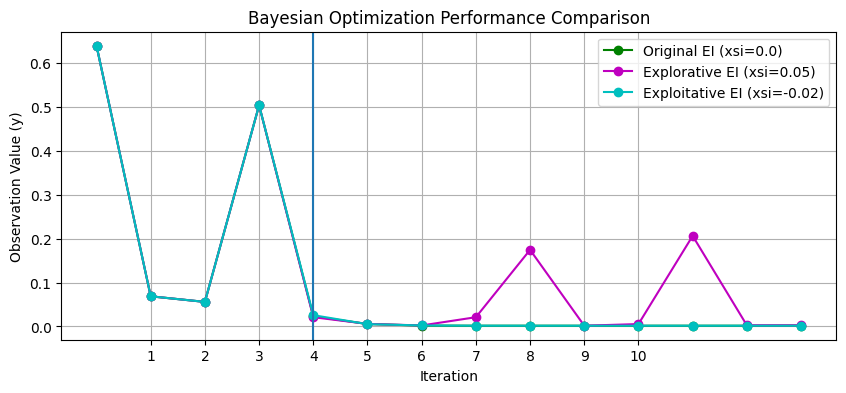

In [9]:
# 7. PLOT THE COMPARISON
plt.figure(figsize=(10, 4))
iterations = np.arange(1, bo_iter + 1)

plt.plot(np.arange(len(orig_obs['OBJECTIVE'].observations)), orig_obs['OBJECTIVE'].observations, 'g-o', label='Original EI (xsi=0.0)')
plt.plot(np.arange(len(explore_obs['OBJECTIVE'].observations)), explore_obs['OBJECTIVE'].observations, 'm-o', label='Explorative EI (xsi=0.05)')
plt.plot(np.arange(len(exploit_obs['OBJECTIVE'].observations)), exploit_obs['OBJECTIVE'].observations, 'c-o', label='Exploitative EI (xsi=-0.02)')
plt.axvline(x=len(initial_dataset.observations))
plt.title('Bayesian Optimization Performance Comparison')
plt.xlabel('Iteration')
plt.ylabel('Observation Value (y)')
plt.legend()
plt.grid(True)
plt.xticks(iterations)
#plt.ylim(0,1)
plt.show()


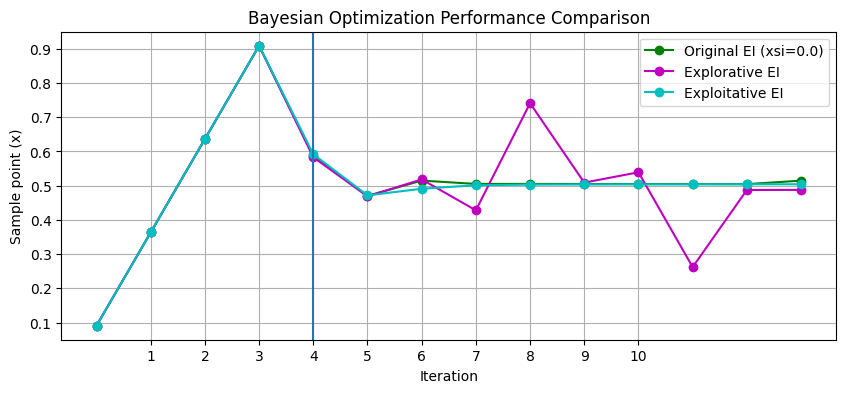

In [10]:
plt.figure(figsize=(10, 4))
iterations = np.arange(1, bo_iter + 1)

plt.plot(np.arange(len(orig_obs['OBJECTIVE'].observations)), orig_obs['OBJECTIVE'].query_points, 'g-o', label='Original EI (xsi=0.0)')
plt.plot(np.arange(len(explore_obs['OBJECTIVE'].observations)), explore_obs['OBJECTIVE'].query_points, 'm-o', label='Explorative EI')
plt.plot(np.arange(len(exploit_obs['OBJECTIVE'].observations)), exploit_obs['OBJECTIVE'].query_points, 'c-o', label='Exploitative EI')
plt.axvline(x=len(initial_dataset.observations))
plt.title('Bayesian Optimization Performance Comparison')
plt.xlabel('Iteration')
plt.ylabel('Sample point (x)')
plt.legend()
plt.grid(True)
plt.xticks(iterations)
plt.show()

## Explicit one-step optimization via AskTell

Equivalent example using ExpectedImprovementXsi with one-step at a time optimization using the same model configuration as above.

In [ ]:
num_steps = 20
# GPR Model
gp_flow_model = build_gpr(initial_dataset, search_space, likelihood_variance=1e-5)
model = GaussianProcessRegression(gp_flow_model)

# Exploitative EI (xsi < 0)
acq = ExpectedImprovementXsi(xsi=-0.02)
rule = EfficientGlobalOptimization(acq)

ask_tell = AskTellOptimizerHistory(search_space=search_space,
                            datasets=initial_dataset,
                            models=model,
                            acquisition_rule=rule,
                            fit_model=True)

print(f"Running ask-tell loop for {num_steps} steps...")

for step in range(num_steps):
    # Get new point recommendation
    new_point = ask_tell.ask()
    
    # Observe the objective function at the new point
    new_obs = functions[fun_name](new_point)
    
    new_data = Dataset(new_point, new_obs)
    # Update the model with the new observation
    ask_tell.tell(new_data)
        
    print(f"Step {step+1:2d}: queried point {new_point.numpy().squeeze()} | objective: {new_data.observations.numpy().squeeze():.3f}")

print("Optimization finished.")

Running ask-tell loop for 20 steps...
Step  1: queried point 0.5920229724011256 | objective: 0.026
Step  2: queried point 0.47178766950429796 | objective: 0.005
Step  3: queried point 0.4911572799726587 | objective: 0.002
Step  4: queried point 0.501432128102565 | objective: 0.002
Step  5: queried point 0.5032094330802738 | objective: 0.002
Step  6: queried point 0.5037289272570431 | objective: 0.002
Step  7: queried point 0.5039704146205233 | objective: 0.002
Step  8: queried point 0.504109637275021 | objective: 0.002
Step  9: queried point 0.5042002665191684 | objective: 0.002
Step 10: queried point 0.5042640125497913 | objective: 0.002
Step 11: queried point 0.5043113534477679 | objective: 0.002
Step 12: queried point 0.5043478955276622 | objective: 0.002
Step 13: queried point 0.5043770202620433 | objective: 0.002
Step 14: queried point 0.5044012647637262 | objective: 0.002
Step 15: queried point 0.5044205059352784 | objective: 0.002


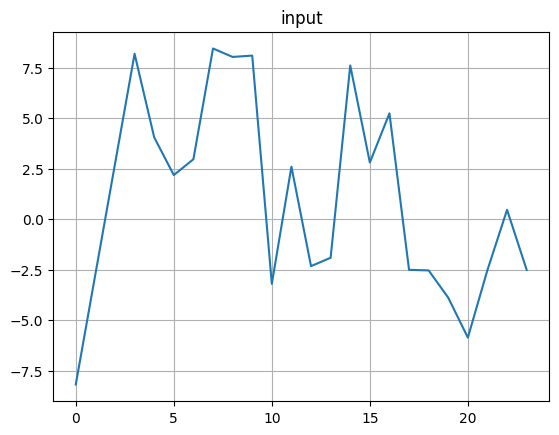

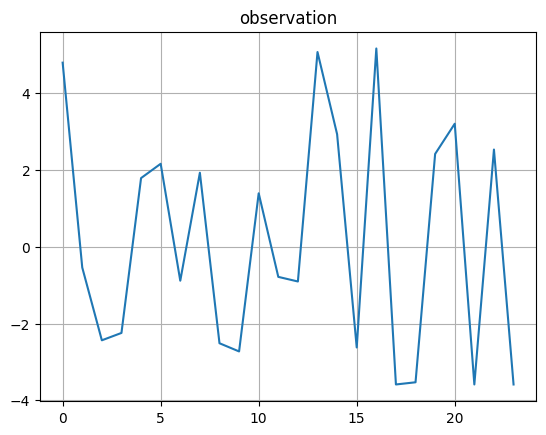

In [ ]:
plt.plot(ask_tell._datasets["OBJECTIVE"].query_points.numpy())
plt.grid()
plt.title("input")
plt.show()

plt.plot(ask_tell._datasets["OBJECTIVE"].observations.numpy())
plt.grid()
plt.title("observation")
plt.show()